1. 전체주석처리된 코드셀은 전혀 보지 않아도 됨. 파일경로는 내 로컬환경에서 가져온게 많으므로 신경안써도 됨. 

2. 보면 다양한 모델을 만들었는데, 이전의 모델에서 사용한 train,test를 그대로 쓰기도 하고 체계가 좀 다양해서 코드셀만 봐서는 깔끔하지 않을 수 있음. 필요할시 얘기하면 각 모델별 정확히 어떤 변수 어떤기법을 사용했나 정리하겠음. 현재 마크다운으로 간략히 표시는 해둠. 

3. **가장 중요한 내용은 (3)결과분석및 모델결정 파트.**
거기에 최종적인 분석내용 정리도 써있으니 발표를 위해 핵심만 보려거든 그쪽 위주로. 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import shap
import joblib
import xgboost as xgb


데이터셋 경로

In [2]:
default_path = '../../jiyoon/asset/default/mhcld_puf_2022.csv'
processed1_path = '../../jiyoon/asset/prepro3/단순결측치 행만 추출.csv'
processed2_path = '../../jiyoon/asset/prepro3/단순결측치 행 제거.csv'
processed3_path = '../../jiyoon/asset/prepro3/단순결측치 행 제거 후 지역별 차이 있는 칼럼 제거.csv'
processed4_path = '../../jiyoon/asset/prepro3/결측치가 포함된 모든 행 제거.csv'
processed5_path = '../../jiyoon/asset/prepro3/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
processed6_path = '../../jiyoon/asset/prepro3/원핫인코딩_단순결측치 행 제거 후 지역별 차이 있는 칼럼 제거.csv'


In [ ]:
# default = pd.read_csv(default_path)
# processed1 = pd.read_csv(processed1_path)
# processed2 = pd.read_csv(processed2_path)
# processed3 = pd.read_csv(processed3_path)
# processed4 = pd.read_csv(processed4_path)
# processed5 = pd.read_csv(processed5_path)
# processed6 = pd.read_csv(processed6_path)


In [ ]:
# print(default.shape)
# print(processed1.shape)
# print(processed2.shape)
# print(processed3.shape)
# print(processed4.shape)
# print(processed5.shape)
# print(processed6.shape)

(6957919, 40)
(1640309, 40)
(5317610, 40)
(5317610, 35)
(1147781, 40)
(1147781, 77)
(5317610, 69)


In [ ]:
# # 전처리 분석
# def describe_dataframes(dfs):
#     for name, df in dfs.items():
#         print(f"{name} Data Shape: {df.shape}")
#         for col in df.columns:
#             print(f"{col}: {df[col].unique()}")
#         print("\n\n\n")

# dataframes = {
#     'Default': default,
#     'Processed1': processed1,
#     'Processed2': processed2,
#     'Processed3': processed3,
#     'Processed4': processed4,
#     'Processed5': processed5,
#     'Processed6': processed6
# }

# describe_dataframes(dataframes)

Default Data Shape: (6957919, 40)
YEAR: [2022]
AGE: [14  7  8  3  4  6  5 11  9  1 12 13  2 10 -9]
EDUC: [-9  3  4  2  5  1]
ETHNIC: [ 3  4  1  2 -9]
RACE: [ 3  4 -9  2  6  5  1]
GENDER: [ 2  1 -9]
SPHSERVICE: [2 1]
CMPSERVICE: [1 2]
OPISERVICE: [2 1]
RTCSERVICE: [2 1]
IJSSERVICE: [2 1]
MH1: [11  7 -9  6 13  5  1  2  3  8  4 10  9 12]
MH2: [-9 11  2  1  3 13  7  8 10  6  5  9  4 12]
MH3: [-9  2  7  1  4  8 11 10  9  3 13  5 12  6]
SUB: [-9  6  8  3 11  4  5 10  9 13 12  7  1  2]
MARSTAT: [ 1  2  4 -9  3]
SMISED: [-9  1  3  2]
SAP: [-9  1  2]
EMPLOY: [-9  4  5  1  2  3]
DETNLF: [-9  1  2  5  3  4]
VETERAN: [-9  2  1]
LIVARAG: [-9  2  3  1]
NUMMHS: [1 2 0 3]
TRAUSTREFLG: [0 1]
ANXIETYFLG: [0 1]
ADHDFLG: [0 1]
CONDUCTFLG: [0 1]
DELIRDEMFLG: [0 1]
BIPOLARFLG: [0 1]
DEPRESSFLG: [0 1]
ODDFLG: [0 1]
PDDFLG: [0 1]
PERSONFLG: [0 1]
SCHIZOFLG: [1 0]
ALCSUBFLG: [0 1]
OTHERDISFLG: [0 1]
STATEFIP: [ 1  2  4  5  6  8  9 10 11 12 13 15 16 17 18 19 20 21 22 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 3

### 5. 진단 수가 0인 사람들: 그들은 왜 진단되지 않았는가

#### (1) 이진 분류모델 만들기

processed6을 기준으로 분석 시도. 로지스틱 회귀를 이용해보자. 

##### 대상 데이터 들여다보기 

In [3]:
# 데이터 로드
dataset6 = pd.read_csv(processed6_path)

In [4]:
# NUMMHS로 이진 타겟 변수 만들기 
# => NUMMHS_binary (0: 정신질환 있음, 1: 정신질환 없음)
dataset6['NUMMHS_binary'] = dataset6['NUMMHS'].apply(lambda x: 1 if x == 0 else 0)

In [ ]:
# # 데이터 생김새 분석.
# print(dataset6.columns)
# print(dataset6.shape)
# print(dataset6.describe(include='all'))

Index(['YEAR', 'AGE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE',
       'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'NUMMHS',
       'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG',
       'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
       'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2',
       'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3',
       'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1',
       'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9',
       'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'SMISED_2', 'SMISED_3',
       'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable',
       'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5',
       'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9'],
      dtype='object')
(5317610, 69)
             YEAR           AGE        GENDER    SPHSERVICE    CMPSERVICE  \

In [ ]:
# # -99의 개수 괜찮은지 확인
# neg99_counts = (dataset6 == -99).sum()
# neg99_counts = neg99_counts[neg99_counts > 0]
# print(neg99_counts)

# print(dataset6["SAP"].value_counts())

MH1     681464
MH2    3487662
MH3    4808751
SAP     443904
dtype: int64
SAP
 2     2886305
 1     1987401
-99     443904
Name: count, dtype: int64


##### 1번모델: 기본

In [ ]:
# 의미 없는 칼럼 제거
X = dataset6.drop(columns=[
    # 필요X
    "YEAR", "CASEID",
    # 컬럼자체가 타겟변수와 연관됨
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3",
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG'])
y = dataset6["NUMMHS_binary"]


# 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 편의성을 위해 모델 저장
joblib.dump(model, '../result/jiyoon/logistic_model_1.pkl')

# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
# => 500만개의 행 전부 사용 시 10분 소요. 

# 모델 성능 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

[[922672   4600]
 [108249  28001]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94    927272
           1       0.86      0.21      0.33    136250

    accuracy                           0.89   1063522
   macro avg       0.88      0.60      0.64   1063522
weighted avg       0.89      0.89      0.86   1063522

ROC AUC: 0.7571623212088003


##### 2번모델: class_weight = 'balanced'

0번(정신질환있음)이 1번(정신질환없음)보다 수가 많아서 생기는 문제 해결 필요

=> class_weight = balanced 이용해 성능 개선 시도. 해당 변수는 1번에 가중치를 좀 더 부여해줌.. 

In [43]:

# 로지스틱 회귀 모델 학습
model = LogisticRegression(max_iter=1000,class_weight='balanced', verbose=1)
model.fit(X_train, y_train)

joblib.dump(model, '../result/jiyoon/logistic_model_2.pkl')
# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))



c:\Users\User\Desktop\workspace\HoduFanClub\20251R0136COSE47101\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min finished


[[597439 329833]
 [ 39283  96967]]
              precision    recall  f1-score   support

           0       0.94      0.64      0.76    927272
           1       0.23      0.71      0.34    136250

    accuracy                           0.65   1063522
   macro avg       0.58      0.68      0.55   1063522
weighted avg       0.85      0.65      0.71   1063522

ROC AUC: 0.7648090663737236


##### SHAP 분석 시도

결과적으로 실패함

'float' object has no attribute 'rint' 라는 에러 계속 발생.. 원인 불명

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

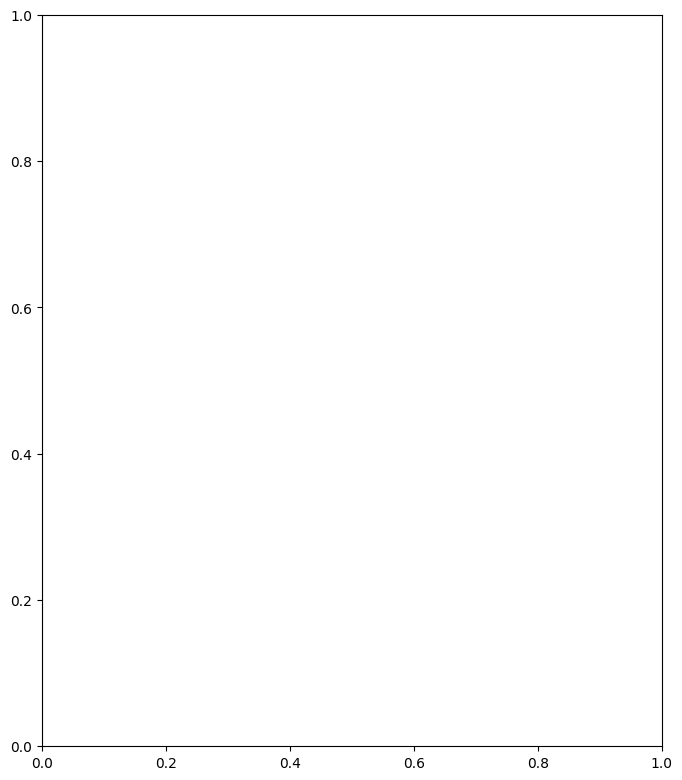

In [46]:
# 1,000개만 해석 (샘플링)
# X_test_sample = X_test.sample(n=100000, random_state=25989812)
# X_filtered = X_test_sample.loc[:, X_test_sample.nunique(dropna=False) > 1]
# X_test


# # SHAP 해석
# explainer = shap.LinearExplainer(model, X_filtered)
# shap_values = explainer(X_filtered)

# # 중요도 시각화
# shap.summary_plot(shap_values, X_filtered)


X_test_df = pd.DataFrame(X_test, columns=X.columns)  # X.columns는 학습용 컬럼
X_test_df1 = X_test_df.sample(n=1000, random_state=25989812)
explainer = shap.Explainer(model, X_test_df1)  # 또는 TreeExplainer
shap_values = explainer(X_test_df1)
shap.summary_plot(shap_values, X_test_df1)

#### (2) XGboost 활용한 모델 제작

##### 3번모델: xgboost로만 바뀜
1번모델과 데이터셋 활용 방식은 같음. 

모델만 logisticregression -> xgboost로 변경 

In [ ]:

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 모델 저장
joblib.dump(xgb_model, '../result/jiyoon/xgboost_model_1.pkl')

# 예측 및 평가
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
# => 성능 뚜렷히 개선됨. 

c:\Users\User\Desktop\workspace\HoduFanClub\20251R0136COSE47101\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[918789   8483]
 [ 91066  45184]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95    927272
           1       0.84      0.33      0.48    136250

    accuracy                           0.91   1063522
   macro avg       0.88      0.66      0.71   1063522
weighted avg       0.90      0.91      0.89   1063522

ROC AUC: 0.8839582524403635


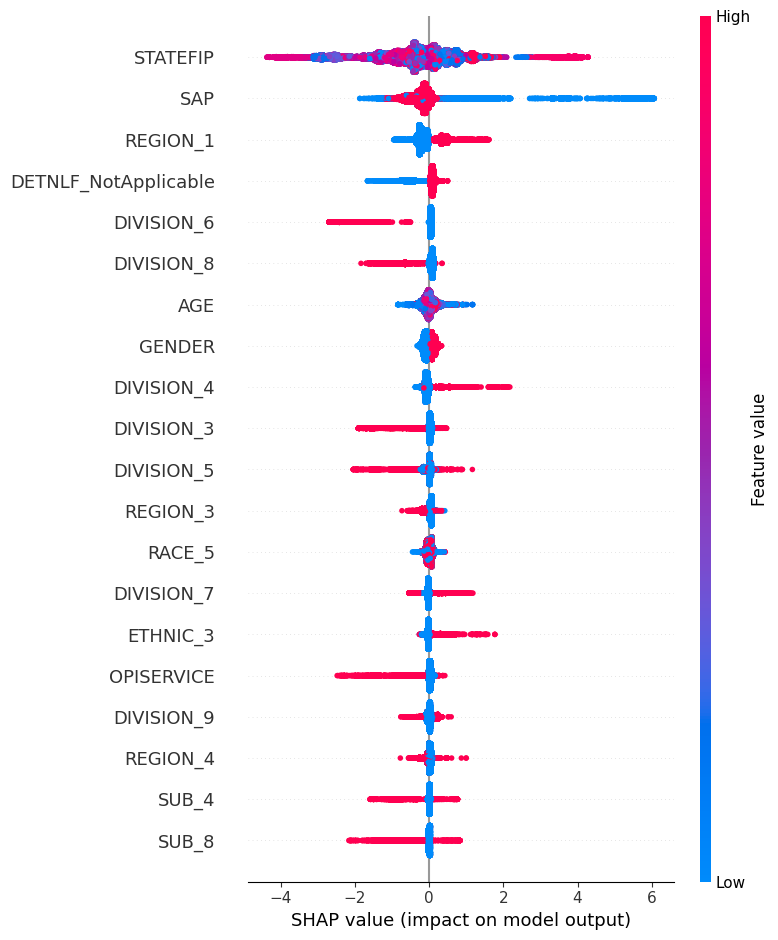

In [ ]:
# shap를 활용한 분석

X_test_sample = X_test.sample(n=100000, random_state=1)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

# 요약 그래프 그리기
shap.summary_plot(shap_values, X_test_sample)

# => 결과 분석 및 더 자세한 방법을 이용한 분석이 필요할듯


##### 4번모델: 지역관련 변수 및 약물사용진단 변수 제거

너무 다양한 값을 가져 모델에 도움이 안 될 거 같은 변수 추가로 제거해봄. 

추가로 제거된 변수: STATEFIP, REGION_1.2.3.4, DIVISION_1.2...9, SUB_1.2...13 

In [ ]:
# NUMMHS로 이진 타겟 변수 만들기 => NUMMHS_binary
dataset6['NUMMHS_binary'] = dataset6['NUMMHS'].apply(lambda x: 1 if x == 0 else 0)

X = dataset6.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
    'STATEFIP', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 
    'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
    ])
y = dataset6["NUMMHS_binary"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

joblib.dump(xgb_model, '../result/jiyoon/xgboost_model_2.pkl')
# 예측 및 평가
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
# => 3번모델과 비교시 성능이 개선되지 않음. 오히려 하락... 1번 클래스를 예측하는 성능이 처참함.. 지역이 중요한 역할을 하는듯? 


c:\Users\User\Desktop\workspace\HoduFanClub\20251R0136COSE47101\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[918457   8815]
 [118006  18244]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    927272
           1       0.67      0.13      0.22    136250

    accuracy                           0.88   1063522
   macro avg       0.78      0.56      0.58   1063522
weighted avg       0.86      0.88      0.84   1063522

ROC AUC: 0.7214595501366503


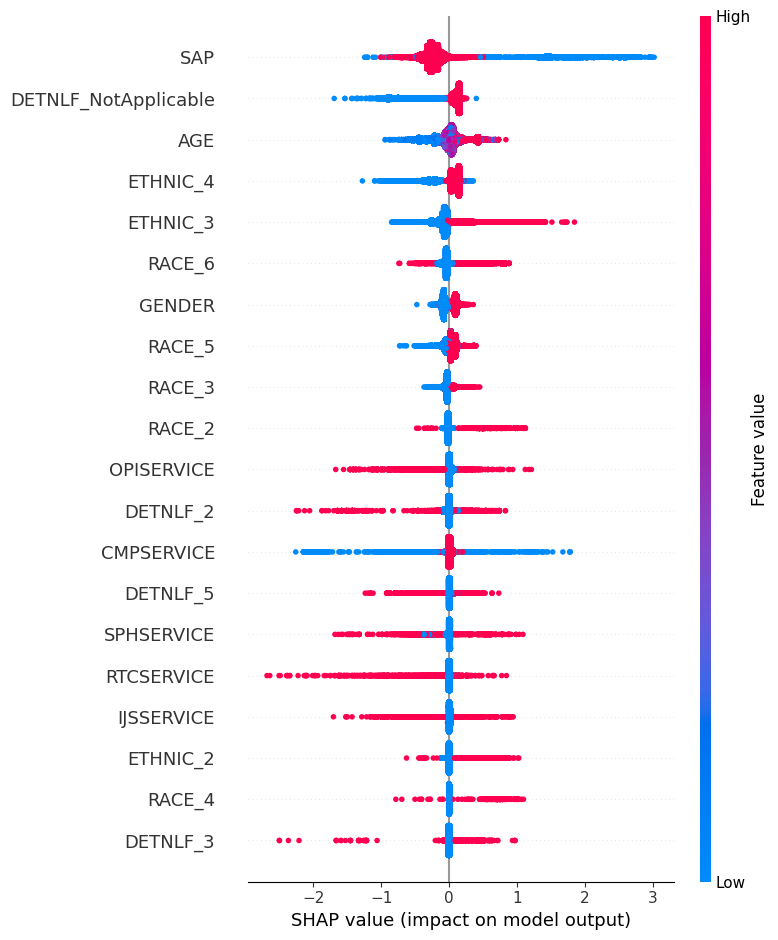

In [ ]:
# shap 분석

# 샘플을 줄여서 빠르게 해보기
X_test_sample = X_test.sample(n=100000, random_state=1)

# TreeExplainer는 트리 모델 전용이라 속도가 빠르고 정확함
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

# 요약 그래프 그리기
shap.summary_plot(shap_values, X_test_sample)

##### 5번모델: 전처리 데이터셋 대신 기본 데이터셋 사용

정규화, 원핫인코딩 등 전처리된 6번 데이터셋을 사용해왔는데, 대신 default 데이터셋을 사용. 

참고: 5번모델만 다른 데이터셋 쓰고, 그 외 모든 모델은 6번 데이터셋을 사용한다. 

In [ ]:
default = pd.read_csv(default_path)
default['NUMMHS_binary'] = default['NUMMHS'].apply(lambda x: 1 if x == 0 else 0)

X = default.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED",
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
    'STATEFIP'
    ])
y = default["NUMMHS_binary"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

joblib.dump(xgb_model, '../result/jiyoon/xgboost_model_3.pkl')
# 예측 및 평가
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# => 3번모델과 비교시 성능 비슷함. 별반 차이가 없다. 

c:\Users\User\Desktop\workspace\HoduFanClub\20251R0136COSE47101\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:50:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[1160496   19310]
 [ 137832   73946]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.94   1179806
           1       0.79      0.35      0.48    211778

    accuracy                           0.89   1391584
   macro avg       0.84      0.67      0.71   1391584
weighted avg       0.88      0.89      0.87   1391584

ROC AUC: 0.8806599429165984


##### 6번모델: 언더샘플링

0번 클래스와 1번 클래스 사이 비율이 크게 차이나는게 근본적 문제점 같아, 둘을 같은 비율로 맞춰주기 위해 수량이 많았던 0번 클래스에 언더샘플링 처리. 

In [ ]:
# 라벨 분리
df_0 = dataset6[dataset6["NUMMHS_binary"] == 0]
df_1 = dataset6[dataset6["NUMMHS_binary"] == 1]

# 1라벨 데이터 수만큼 0라벨에서 샘플링
df_0_under = df_0.sample(n=len(df_1), random_state=42)

# 합치기
balanced_df = pd.concat([df_0_under, df_1])

# 셔플 (순서 무작위화)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X = balanced_df.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG'])
y = balanced_df["NUMMHS_binary"]


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

joblib.dump(xgb_model, '../result/jiyoon/xgboost_model_4.pkl')
# 예측 및 평가
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# => 1번 클래스를 예측하는 성능이 개선. 대신 0번 클래스는 성능이 조금 떨어짐. 
# 주의점: test set까지 언더샘플링을 적용했으므로, 편향된 결과일 수 있다. 

c:\Users\User\Desktop\workspace\HoduFanClub\20251R0136COSE47101\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[104085  32092]
 [ 24275 112134]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.79    136177
           1       0.78      0.82      0.80    136409

    accuracy                           0.79    272586
   macro avg       0.79      0.79      0.79    272586
weighted avg       0.79      0.79      0.79    272586

ROC AUC: 0.884315034213616


##### 7번모델: 언더샘플링-train에만 적용

위와 같은 기법. 그러나 결과를 보니 test 정확도가 의심되어, test데이터는 언더샘플링 하지 않고 그대로 둠. 

In [7]:
dataset6['NUMMHS_binary'] = dataset6['NUMMHS'].apply(lambda x: 1 if x == 0 else 0)

In [8]:
train_df, test_df = train_test_split(
    dataset6,
    test_size=0.2,
    stratify=dataset6["NUMMHS_binary"],  # 클래스 비율 유지
    random_state=42
)

# 클래스별 나누기
train_0 = train_df[train_df["NUMMHS_binary"] == 0]
train_1 = train_df[train_df["NUMMHS_binary"] == 1]

# 1과 같은 수로 0에서 샘플링
train_0_under = train_0.sample(n=len(train_1), random_state=42)

# 언더샘플된 학습 데이터
train_balanced = pd.concat([train_0_under, train_1]).sample(frac=1, random_state=42)

# 타겟
y_train = train_balanced["NUMMHS_binary"]
y_test = test_df["NUMMHS_binary"]

X_train = train_balanced.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG'])
X_test = test_df.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG'])


# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

joblib.dump(xgb_model, '../result/jiyoon/xgboost_model_5.pkl')
# 예측 및 평가
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
# => 성능 괜찮은거같기도.. 

c:\Users\User\Desktop\workspace\HoduFanClub\20251R0136COSE47101\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:26:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[709319 217910]
 [ 24778 111515]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85    927229
           1       0.34      0.82      0.48    136293

    accuracy                           0.77   1063522
   macro avg       0.65      0.79      0.67   1063522
weighted avg       0.89      0.77      0.81   1063522

ROC AUC: 0.8834830860675882


우리가 원하는 타겟인 1(정신질환없음)을 얼마나 잘 분류했는지 살펴 본 결과, 
precision = 0.34 로 꽤 낮았다. 모델이 정신질환이 없다고 예측한 행 중 실제로 정신질환이 없던 사람들이 34퍼센트. 
recall = 0.82로 꽤 높았다. 실제 정신질환이 없는 사람들 중 모델이 예측에 성공한 비율이 82퍼센트. 

#### (3) 결과 분석 및 모델 결정

(1), (2)에서 만든 모델의 결과를 비교해보자. 

1~6번 모델들은 precision이 높고, recall이 낮은 경향성이 있다. 

7번 모델은 반대로 precision이 낮고, recall이 높다. 


이는 7번모델이 실제 정신질환 없는 사람들을 잘 잡아낸다고 볼 수 있으며, 우리 분석의 목적인 “진단을 받지 않은 사람들, 그들은 진짜 질환이 없었을까? 아니면 위험군인데 누락된 걸까?”에 부합한다고 볼 수 있다. 

이에따라 언더샘플링+XGBoost 를 활용한 7번 모델을 최종모델로 선정. 해당 모델을 기반으로 분석을 조금 더 이어나가자. 

##### 목표
1. 진단을 받지 않은 사람들(예측값 1) 중, 어떤 변수들이 '1'이라고 판단되게 만들었는지 파악한다.
2. 특히 `True Positive`와 `False Negative`의 샘플들을 비교하여 어떤 특성 차이 때문에 예측이 엇갈렸는지를 분석한다.
3. SHAP을 활용하여 주요 변수의 영향력을 시각적으로 확인한다.


In [5]:
train_df, test_df = train_test_split(
    dataset6,
    test_size=0.2,
    stratify=dataset6["NUMMHS_binary"],  # 클래스 비율 유지
    random_state=42
)

# 클래스별 나누기
train_0 = train_df[train_df["NUMMHS_binary"] == 0]
train_1 = train_df[train_df["NUMMHS_binary"] == 1]

# 1과 같은 수로 0에서 샘플링
train_0_under = train_0.sample(n=len(train_1), random_state=42)

# 언더샘플된 학습 데이터
train_balanced = pd.concat([train_0_under, train_1]).sample(frac=1, random_state=42)

# 타겟
y_train = train_balanced["NUMMHS_binary"]
y_test = test_df["NUMMHS_binary"]

X_train = train_balanced.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG'])
X_test = test_df.drop(columns=[
    "YEAR", "CASEID",
    "NUMMHS", "NUMMHS_binary", "MH1", "MH2", "MH3", 
    "SMISED_2", "SMISED_3", 
    'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG'])


✅ 전체 샘플의 SHAP 변수 영향력 (bar plot)


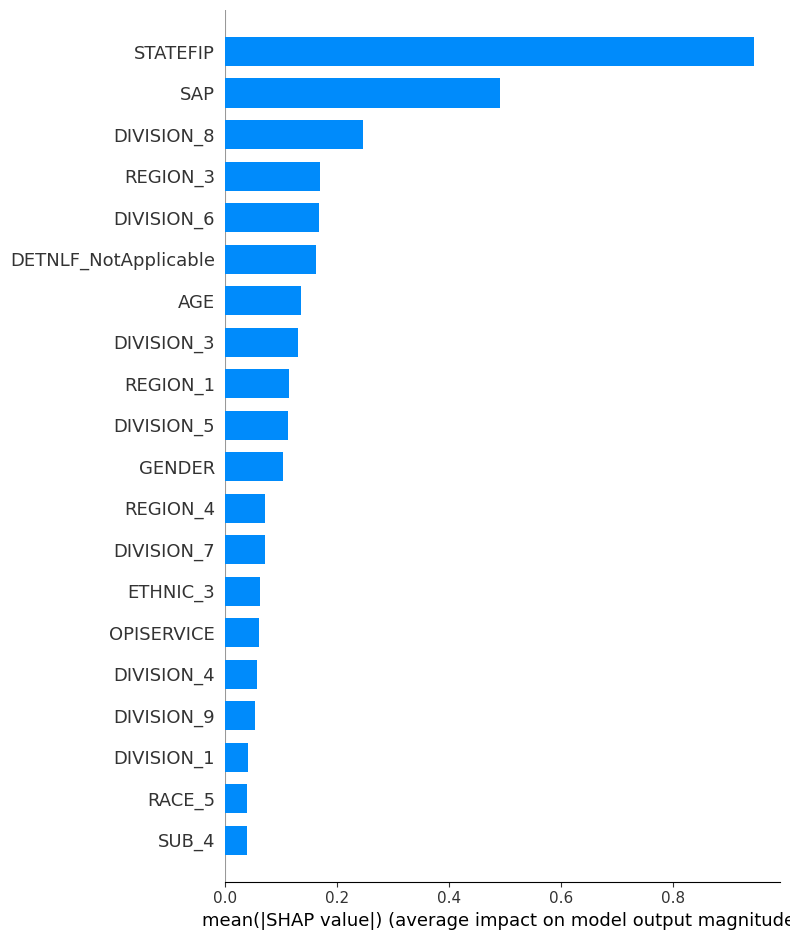

✅ SHAP summary for True Positives (예측 1 맞춘 사람들)


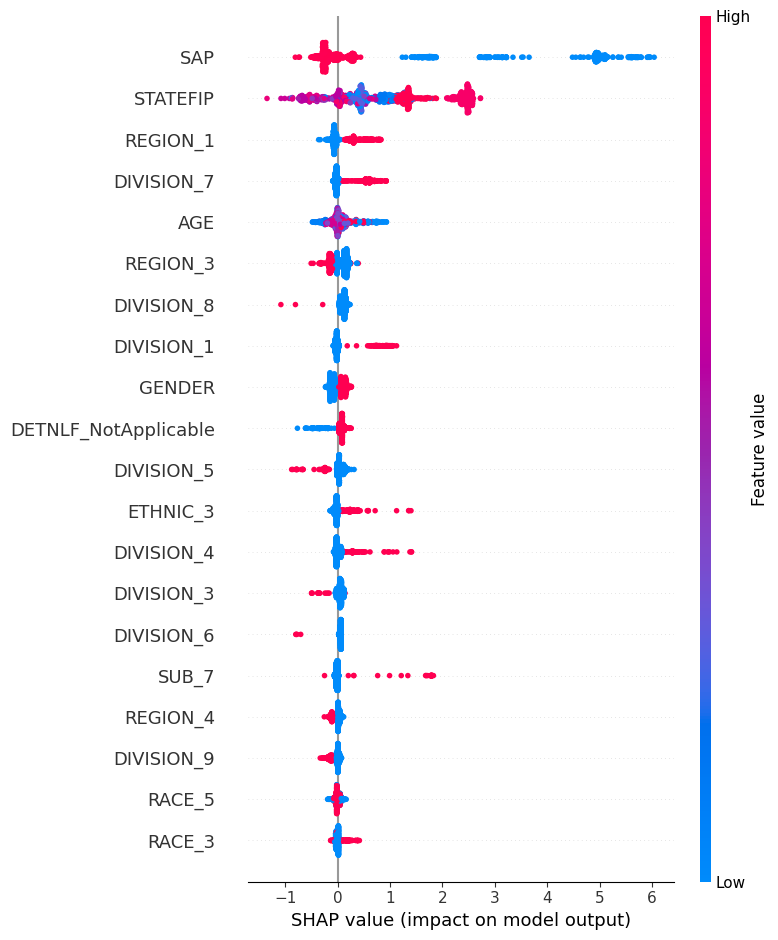

✅ SHAP summary for False Negatives (예측 0 → 실제는 1)


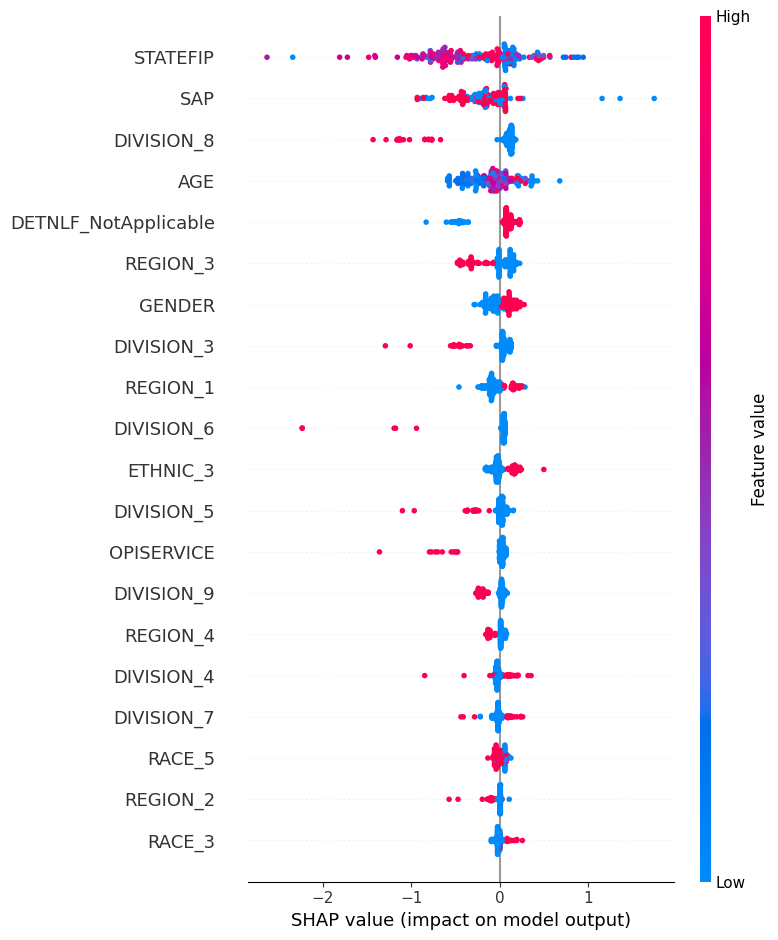

In [6]:
# 모델 로딩
xgb_model = joblib.load('../result/jiyoon/xgboost_model_5.pkl')

# SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# ❷ X_test에서 10,000개 샘플링 (SHAP용)
X_test_sample = X_test.sample(n=10000, random_state=1)
y_test_sample = y_test.loc[X_test_sample.index]

# ❸ SHAP Explainer 생성
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

# ❹ 예측 수행
y_pred_sample = xgb_model.predict(X_test_sample)
y_prob_sample = xgb_model.predict_proba(X_test_sample)[:, 1]

# ❺ 전체 샘플에 대한 변수 영향력 (bar plot)
print("✅ 전체 샘플의 SHAP 변수 영향력 (bar plot)")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

# ❻ Confusion Matrix 기반 마스크 생성
TP_idx = (y_test_sample == 1) & (y_pred_sample == 1)
FN_idx = (y_test_sample == 1) & (y_pred_sample == 0)

# ❼ TP/FN 샘플 분리
X_TP = X_test_sample[TP_idx]
X_FN = X_test_sample[FN_idx]

shap_TP = shap_values[TP_idx]
shap_FN = shap_values[FN_idx]

# ❽ 각각 요약 그래프
print("✅ SHAP summary for True Positives (예측 1 맞춘 사람들)")
shap.summary_plot(shap_TP, X_TP)

print("✅ SHAP summary for False Negatives (예측 0 → 실제는 1)")
shap.summary_plot(shap_FN, X_FN)

##### SHAP 분석

---

**1. 전체 SHAP 분석 결과 요약**

모델이 예측을 수행할 때 어떤 변수들이 전반적으로 중요한 영향을 미쳤는지를 확인하기 위해 전체 테스트 샘플(10,000개)을 대상으로 SHAP summary plot을 생성하였다.

분석 결과, 모델의 예측에 가장 큰 영향을 준 변수는 다음과 같았다:

- **STATEFIP**: 클라이언트가 속한 주(state) 정보. 주마다 정책이나 보고 관행이 달라 예측에 큰 영향을 줌.
- **SAP**: 물질 사용 문제 여부. 모델은 이 변수를 매우 강하게 반영하여 판단함.
- **DIVISION_8**, **REGION_3**, **DIVISION_6** 등 지역 관련 변수들도 예측의 중요한 기준으로 작용.
- **AGE**, **GENDER**, **DETNLF_NotApplicable**(비경제활동자 사유 미적용) 등도 중간 수준 이상의 영향을 가짐.

이 결과는 모델이 **클라이언트의 지역적 특성, 물질 사용 이력, 연령, 성별 등**을 종합적으로 고려하여 진단 유무를 판단하고 있음을 보여준다.

---

**2. TP vs FN 비교 분석**

예측 성능의 한계를 살펴보기 위해, 다음 두 그룹에 대해 SHAP 값을 비교하였다:

- **True Positive (TP)**: 실제로 진단을 받지 않았고, 모델도 이를 정확히 1로 예측한 그룹
- **False Negative (FN)**: 실제로는 진단을 받았지만, 모델이 잘못 0이라고 예측한 그룹 (모델이 놓친 위험군)

**2-1. TP 그룹의 특징 (모델이 잘 예측한 경우)**

- **SAP 값이 낮거나 없음** → 모델이 “물질 사용 문제 없음”을 진단 없음의 강한 신호로 받아들임.
- **STATEFIP**는 특정 주에서 예측 일관성이 있었음.
- 전반적으로 SHAP 값의 분포가 넓고 명확히 한쪽 방향으로 치우쳐 있었음

**2-1. FN 그룹의 특징 (모델이 놓친 경우)**

- **SAP**가 있음에도 불구하고 모델이 진단이 없다고 예측함 → SAP 정보가 일부 샘플에서는 예측에 충분히 작용하지 않았음.
- SHAP 값들이 전체적으로 작고 0 주변에 몰려 있음 → 모델이 해당 샘플들에 대해 **확신이 없었고 모호한 판단**을 내렸음을 시사.
- `STATEFIP`, `AGE`, `DIVISION_8` 등의 변수는 여전히 중요하게 나타나지만, 방향성이나 강도가 약해짐.
- 즉, **모델이 학습한 일반적인 진단 예측 패턴에서 벗어난 경우들**이라고 볼 수 있음.

---

**3. 결론 및 시사점**

이번 SHAP 분석은 모델이 어떤 기준으로 "진단되지 않음"이라고 예측했는지를 구체적으로 설명해주었으며, 동시에 **모델이 놓친 고위험군(FN)**의 특징도 드러내 주었다.

- **모델은 SAP, STATEFIP, AGE 등의 변수에 강하게 의존**하여 진단 유무를 예측하고 있었다.
- 하지만 일부 FN 그룹에서는 이 변수들이 **예측에 충분히 작용하지 않거나**, **일반적인 조합이 아니었던 경우**, 모델이 진단 여부를 잘못 예측함.
- 이로부터, **모델은 현재 일반적인 위험군은 잘 예측하지만, 패턴이 다소 다른 비정형 사례에는 취약함**을 알 수 있다.

> 따라서 향후 분석에서는 FN에 해당하는 사례들에 대한 **군집 분석**, **특이 패턴 탐지**, 또는 **모델 구조 보완 (예: 앙상블, 계층적 분류 등)**이 필요할 수 있다.  
> 또한, SHAP 분석을 통해 확보한 변수 영향력 정보를 토대로 **설명 가능한 정책적 시사점** 도출이 가능하다. 예: 특정 주에서 진단 누락 비율이 높다면, 해당 주의 정책 또는 보고체계 점검 필요 등.



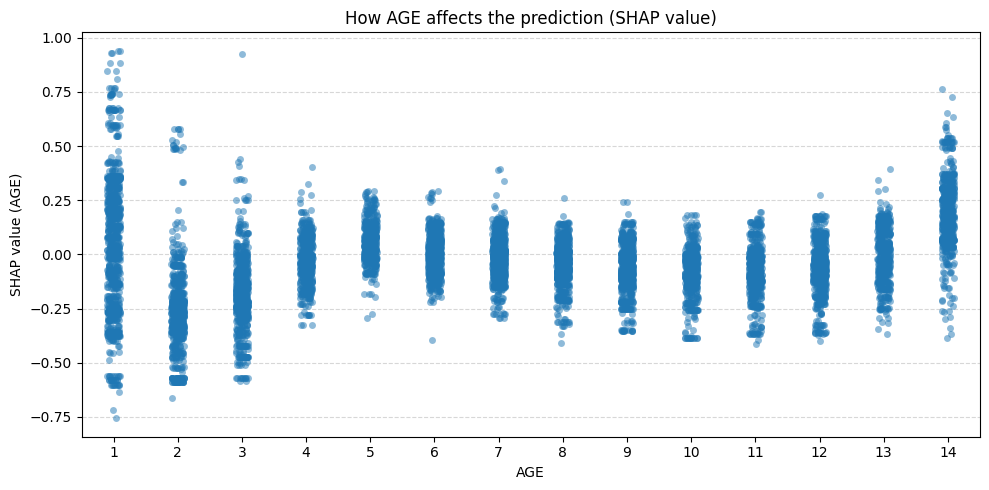

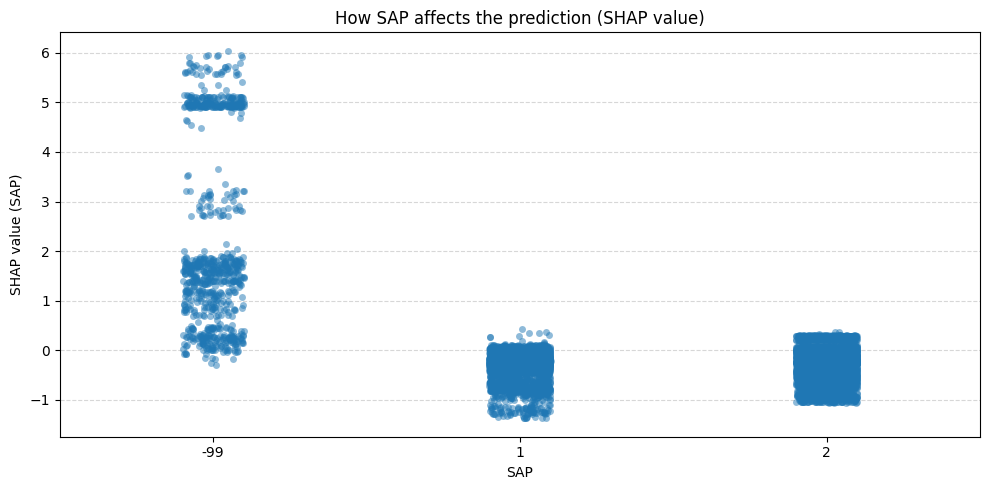

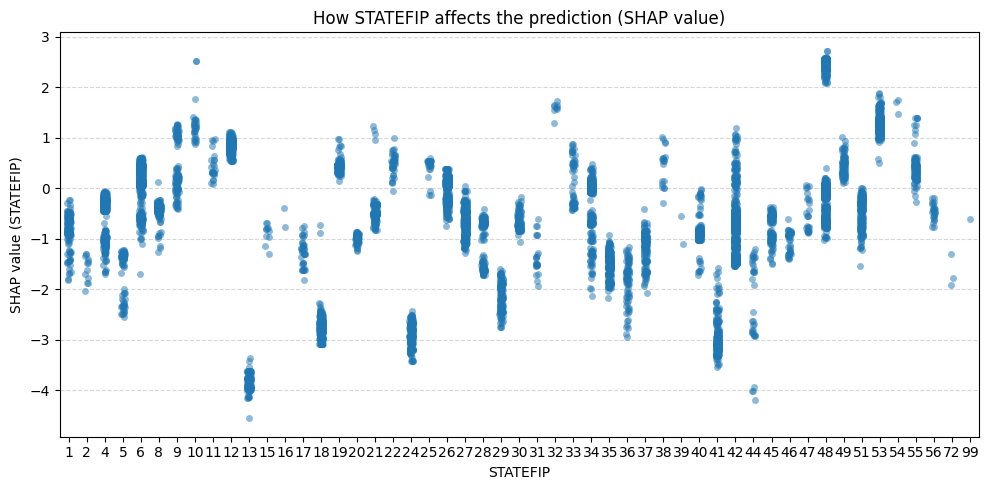

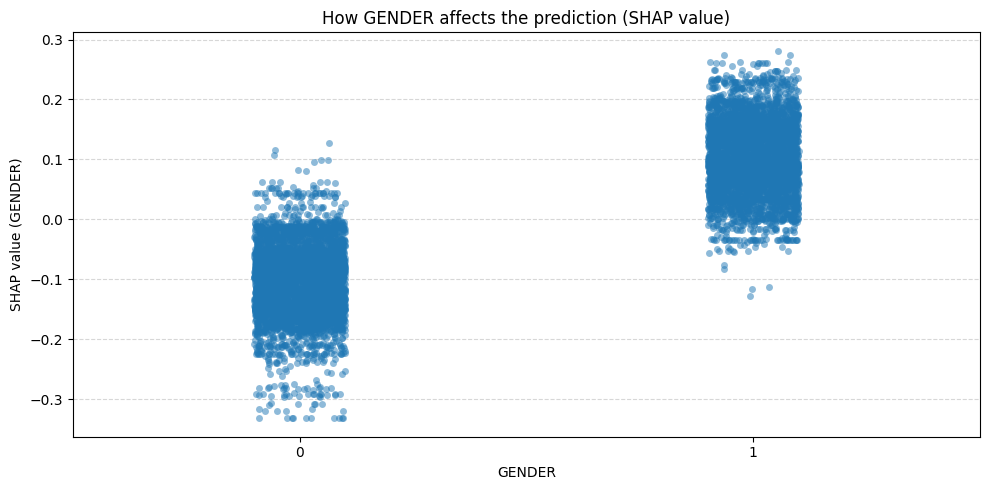

In [8]:
# SHAP 기여도 확인: AGE, SAP, STATEFIP 변수에 대한 SHAP 값 시각화

# 1. AGE
# AGE 범주 복원 (0~1 → 1~14)
X_test_sample["AGE_CAT"] = (X_test_sample["AGE"] * 13 + 1).round().astype(int)
age_idx = list(X_test_sample.columns).index("AGE")
plt.figure(figsize=(10, 5))
sns.stripplot(x=X_test_sample["AGE_CAT"], y=shap_values[:, age_idx], jitter=True, alpha=0.5)
plt.xlabel("AGE")
plt.ylabel("SHAP value (AGE)")
plt.title("How AGE affects the prediction (SHAP value)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. SAP
sap_idx = list(X_test_sample.columns).index("SAP")
plt.figure(figsize=(10, 5))
sns.stripplot(x=X_test_sample["SAP"], y=shap_values[:, sap_idx], jitter=True, alpha=0.5)
plt.xlabel("SAP")
plt.ylabel("SHAP value (SAP)")
plt.title("How SAP affects the prediction (SHAP value)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. STATEFIP
state_idx = list(X_test_sample.columns).index("STATEFIP")
plt.figure(figsize=(10, 5))
sns.stripplot(x=X_test_sample["STATEFIP"], y=shap_values[:, state_idx], jitter=True, alpha=0.5)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value (STATEFIP)")
plt.title("How STATEFIP affects the prediction (SHAP value)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. GENDER
gender_idx = list(X_test_sample.columns).index("GENDER")
plt.figure(figsize=(10, 5))
sns.stripplot(x=X_test_sample["GENDER"], y=shap_values[:, gender_idx], jitter=True, alpha=0.5)
plt.xlabel("GENDER")
plt.ylabel("SHAP value (GENDER)")
plt.title("How GENDER affects the prediction (SHAP value)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# 어떤 STATE가 큰 영향을 미치는지. 
# STATEFIP의 SHAP 인덱스 가져오기
statefip_idx = list(X_test_sample.columns).index("STATEFIP")

# SHAP 값과 STATEFIP 값을 묶은 데이터프레임 생성
shap_df = pd.DataFrame({
    "STATEFIP": X_test_sample["STATEFIP"],
    "SHAP": shap_values[:, statefip_idx]
})

# STATEFIP별 평균 SHAP 값 계산
mean_shap_by_state = shap_df.groupby("STATEFIP")["SHAP"].mean().sort_values(ascending=False)

# 상위 3개와 하위 3개 추출
top3 = mean_shap_by_state.head(3)
bottom3 = mean_shap_by_state.tail(3)

# 결과 출력
print("✅ SHAP값 높은 상위 3개 주:\n", top3)
print("\n✅ SHAP값 낮은 하위 3개 주:\n", bottom3)


✅ SHAP값 높은 상위 3개 주:
 STATEFIP
54    1.646119
32    1.586921
53    1.298797
Name: SHAP, dtype: float32

✅ SHAP값 낮은 하위 3개 주:
 STATEFIP
24   -2.889230
41   -2.955250
13   -3.824853
Name: SHAP, dtype: float32


**추가 분석** 
1. STATEIP가 특정 주에서 예측 일관성이 있다고 하는데 그게 어떤 주인지 혹시 알아봤어? 

=> 기본적으로 주별로 예측경향이 꽤 차이남. 그래서 상위 3개 하위3개 뽑아봄.
질환 0개일 확률 높은 주: 54(West Virginia), 32(Nevada), 53(Washington)
질환 1개이상일 확률 높은 주: 24(Maryland), 41(Oregon), 13(Georgia)

2. 그리고 혹시 결론은 SAP, STATEFIP, AGE 이렇게 3개의 변수와 진단이 0일 때의 관계를 반영하고 있다. 이렇게 해석해도 될까?

=> 될거같다. 다만 AGE는 전체 SHAP분석을 봤을때 나머지 두개 변수에 비해 약한 영향이긴함. 

3. AGE, STATEIP, SAP 이렇게 3개는 세부적으로 어떤 경우인지 (EX) 나이가 많다, 적다 등. 이런 거에서 어떤 경향성을 보였는지도 혹시 얘기해줄 수 있을까

=>
AGE: 나이가 어릴수록 질환이 없을 확률이 높음. 나이가 많을수록 질환이 잇을 확률이 높은 경향성을 보임.

SAP: -99인 경우 질환이 없을 확률이 매우 높은 경향이 있음. 
1(물질사용문제있음)과 2(없음)는 모두 질환이 있을 확률이 높다고 나오는 것에 기여함. 

STATEFIP: 주별로 커다란 편차를 가짐. 자세한건 이미 1번에 서술.  

+GENDER: 1(여성)이 0(남성)보다 정신질환 0개로 나올 가능성이 조금 더 높음. 기여도 자체는 작은 편. 
